Classification of people's voices to identify the speaker - [notebook](https://github.com/fastai/course-v3/blob/master/nbs/dl2/audio.ipynb)

**Todos**
*   Re

### Import KD Libraries

In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [3]:
import IPython.core.debugger as db
from pathlib import Path

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
gd_path = 'gdrive/My Drive/Colab Data/fastai-v3'  #change dir to your project folder
gn_path = 'gdrive/My Drive/Colab Notebooks'  #change dir to your project folder

import sys
sys.path.insert(1, gn_path + '/exp')

In [ ]:
!pip install torchaudio

In [11]:
from nb_util import save_pickle, load_pickle, DebugRand
from nb_audio import AudioUtil
from nb_data import AudioClassificationDataBundle
from nb_arch import ArchBase, CNNArch, GeneralRelu, BatchNorm, InitConv
from nb_app import AppBase

### Define data paths

In [12]:
app_dir='audio'

root_path = Path.cwd()
download_path = root_path/app_dir
data_path = download_path

pickle_dir = root_path/'pickle'

### Download data

In [ ]:
dsid = "ST-AEDS-20180100_1-OS"
!wget 'http://www.openslr.org/resources/45/{dsid}.tgz'

import tarfile
tf = tarfile.open(f'{dsid}.tgz')
tf.extractall(download_path)
list(download_path.iterdir())[:10]

### Explore Data

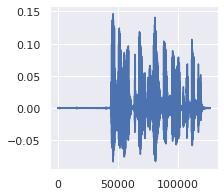

In [14]:
test_file = download_path/'m0003_us_m0003_00064.wav'
test_aud = AudioUtil.open(test_file)
AudioUtil.play(test_aud)
AudioUtil.show_wave(test_aud)

### Build Audio Classification Architecture

In [15]:
#----------------------------------------------------
# Create the Audio Classification architecture
#----------------------------------------------------
class ArchAudioClassification(ArchBase):
  # ----------------------------
  # Create the model
  # ----------------------------
  def create_model(self, n_classes):
    super().__init__()
    cnn_fn = CNNArch(relu_fn=GeneralRelu, bn_fn=BatchNorm, init_conv_fn=InitConv("normal", a=0.1))
    model, _ = cnn_fn(n_classes, False)
    # !!!!!!!! Remove the first FuncLayer which is hardcoded to resizing to mnist (28, 28) shape
    self.model = model[1:]


### Define Audio Classification application class

In [16]:
#----------------------------------------------------
# Audio Classification Application
#----------------------------------------------------
class AppAudioClassification(AppBase):
  def __init__(self):
    super().__init__(loss_type='multi_classif', metrics_cbs=[])

  # ----------------------------
  # Create the architecture
  # ----------------------------
  def create_arch(self):
    self._arch = ArchAudioClassification()
    self._arch.create_model(n_classes=len(self.vocab_y))
    return self._arch

  #----------------------------------------------------
  # Load the data using the Audio Classification Data Bundle
  #----------------------------------------------------
  def load_data(self, file_path):
    self.db = AudioClassificationDataBundle(file_path)
    self.db.process()
    self.vocab_y = self.db.convert_state_y['class_vocab_i2n']


### Load Data

In [ ]:
ac_app = AppAudioClassification()
ac_app.load_data(download_path)
save_pickle(ac_app, pickle_dir, 'proc_data.pkl')

### Train model

In [18]:
DebugRand.set_seed(0)
ac_app = load_pickle(pickle_dir/'proc_data.pkl')

ac_app.create_arch()
ac_app._arch.save_weights(pickle_dir/'arch_init_wgts.mdl')
ac_app._arch.load_weights(pickle_dir/'arch_init_wgts.mdl')

ac_app.create_debug(use_dtr=True, track_batches_per_epoch=15, disp_tb=False, disp_pd=True, debug_bkwd=False, debug_fwd=False, abort_iter=0)

In [19]:
find_lr = True
if (find_lr):
  loop = ac_app.lr_find(start_lr=1e-7, end_lr=10, num_iter=100, weight_decay=0.1)

In [20]:
loop = ac_app.run_train(num_epochs=1, split_lr=[1e-2], weight_decay=0.1, one_cycle=True)

epoch,tr_loss,smooth_loss,val_loss,time
0,1.947613,1.543895,10.596170,00:11


### Display Metrics

(None, None)

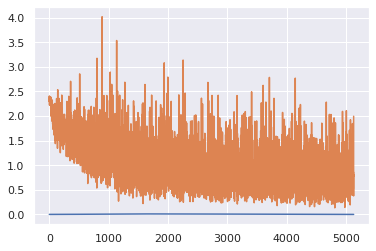

In [ ]:
recorder=loop.cbs[1]
recorder.plot_lr(), recorder.plot_loss()

In [ ]:
is_run_df, is_batch_df, is_layer_df, _ = loop.dtr.pd_results()
is_run_df
is_batch_df.head(2)
is_layer_df.head(2)

,run_id,num_epochs,row_type,epoch_id,num_tr_batches,num_val_batches,tr_loss,smooth_loss,val_loss,time
0,Run-20200902_125335,10.0,run,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Run-20200902_125335,NaN,epoch,0.0,513.0,128.0,1.783401,1.596146,1.394593,00:11
32,Run-20200902_125335,NaN,epoch,1.0,513.0,128.0,1.322697,1.252633,1.142138,00:11
63,Run-20200902_125335,NaN,epoch,2.0,513.0,128.0,1.118727,1.000213,2.886582,00:11
94,Run-20200902_125335,NaN,epoch,3.0,513.0,128.0,1.011536,1.008048,0.892014,00:11
125,Run-20200902_125335,NaN,epoch,4.0,513.0,128.0,0.912532,0.895393,0.621401,00:11
156,Run-20200902_125335,NaN,epoch,5.0,513.0,128.0,0.889057,0.897215,0.763515,00:11
187,Run-20200902_125335,NaN,epoch,6.0,513.0,128.0,0.848241,0.768907,0.606842,00:11
218,Run-20200902_125335,NaN,epoch,7.0,513.0,128.0,0.796976,0.788308,0.526866,00:11
249,Run-20200902_125335,NaN,epoch,8.0,513.0,128.0,0.774545,0.760454,0.525521,00:11


,run_id,row_type,epoch_id,batch_id,iter,batch_type,pred,loss,lr,mom,betas_2,eps,weight_decay,amsgrad
2,Run-20200902_125335,batch,0.0,0-0,0.0,train,-0.022744,2.228701,0.0004,0.95,0.99,1.000000e-08,0.1,False
3,Run-20200902_125335,batch,0.0,0-1,1.0,train,-0.022798,2.408206,0.0004,0.95,0.99,1.000000e-08,0.1,False


""


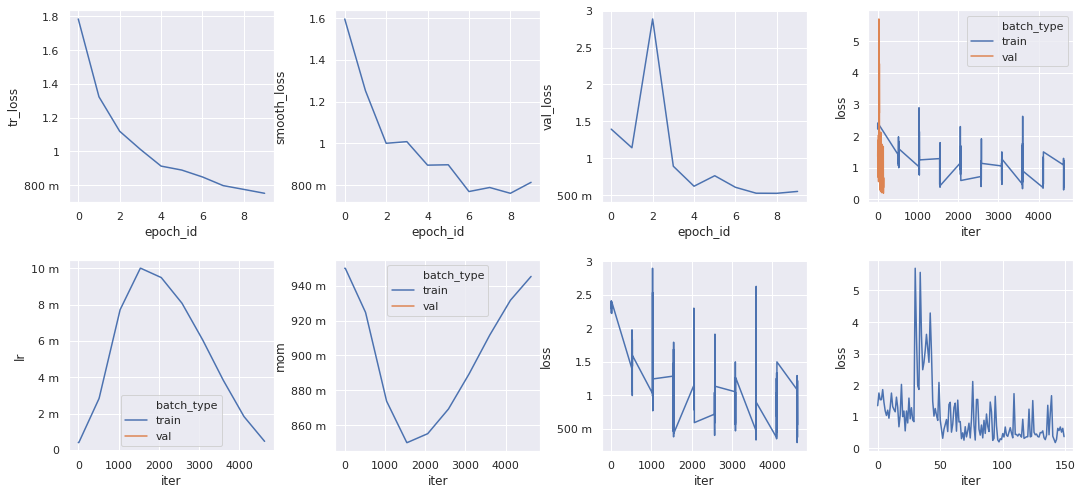

In [ ]:
loop.dtr.pd.display_metrics(is_run_df, is_batch_df, app_metrics=[])